# Auswertung der Rohdaten

Ergebnisse der Umfrage zum Klimaneutralen Stromsystem / Erneuerbaren Energiesystem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Einstellungen zur Darstellung
# Farbpalette (kann später mit eigenen Farben angepasst werden)
# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html
cmap = cm.get_cmap('viridis')

In [3]:
# Gruppierung der Ergebnisse
links = ['E-Mailverteiler', 'internes-Netzwerk', 'Pressemitteilung']
states = ['vollständig', 'abgebrochen']
# Für Grafiken
nrows = 1 #len(states)
ncols = 1 #len(links)

In [4]:
# Laden der Umfrageergebnisse
# Funktion zum Bereinigen der Ergebnisse
def cleanse(df):
    mask = (df['duration']>0) \
        & (df['lastpage']>0) \
        & (df['dispcode'].isin([31,32,33,34,22]))
    return df.loc[mask]

# Funktion zum Laden, Filtern und Bereinigen der Daten
def load_df(link, skipped):
    df = pd.read_csv('data/2022_06_RLI_Klimaneutrales Stromsystem_{}_Ergebnisse.csv'.format(link),
                     sep=';', header=2, usecols=list(range(3,123)))
    df = cleanse(df)
    skip_codes = [22] if skipped else [31,32,33,34]
    return df.loc[df['dispcode'].isin(skip_codes)]

# Tabelle mit Datentabellen
'''data = pd.DataFrame(data={link: [load_df(link, skip) for skip in range(len(states))]
                          for link in links},
                    index=states)'''
data = pd.concat([load_df(link, skipped) for link in links for skipped in [True, False]]).reset_index()

# Access a DataFrame with df.loc[<vollständig/abgebrochen>, <Umfragelink-typ>]

In [5]:
# Importiere Codebook in dict format
from src import rls_umfrage_auswertung
codebook = rls_umfrage_auswertung.main_preprocessing_codebook()

{4: {'columns': ['v_129', 'v_130', 'v_131'],
     'question': 'Welche drei zentralen Eigenschaften beschreiben aus Deiner '
                 'Sicht das „Klimaneutrale Stromsystem“? (q_47502 - Typ 143)'},
 5: {'question': 'Begriffe sind manchmal nicht eindeutig definiert. Auf das '
                 'klimaneutrale Stromsystem gibt es verschiedene Sichtweisen. '
                 'Was trifft aus Deiner Sicht zu?„Klimaneutrales Stromsystem“ '
                 'und „Erneuerbares Stromsystem“? sind ein Synonym. (q_47505 - '
                 'Typ 111)',
     'subquestion': {1: {'columns': 'v_137',
                         'multiple-choice-options': {'1': 'Ja',
                                                     '2': 'Eher ja',
                                                     '3': 'Eher nein',
                                                     '4': 'Nein'},
                         'question': 'Synonyme KS & ES'}}},
 6: {'columns': 'v_138',
     'question': 'Was ist der Unterschied zwisc

In [6]:
# Codes, die Bedeuten, dass keine Angabe gemacht wurde
exclude_codes = [-77, -99, -66, 0, '0', '-66', '-99', '-77']

In [7]:
def pie_plots(code, title=None, sub=1):
    key = codebook[code]['subquestion'][sub]['columns']
    codes = codebook[code]['subquestion'][sub]['multiple-choice-options']
    fig, axis = plt.subplots(nrows, ncols, figsize=(5*ncols,4*nrows))
    data[key] = data[key].astype(str).sort_values().replace(codes)
    data.loc[~data[key].isin(exclude_codes)].groupby(key).count()['dispcode'].plot.pie(ax=axis, cmap=cmap)
    if not title:
        title = codebook[code]['question'][:min(len(codebook[code]['question']), 150)] \
            + '\n' + codebook[code]['subquestion'][sub]['question']
    axis.set_title(title)

In [8]:
def print_data(key, agg, title=None, codes=None, gap=False):
    if title:
        print(str(title))
        if gap: print('')
    if codes:
        data[key] = data[key].astype(str).replace(codes)
    if agg == list:
        result = list(data.loc[~data[key].isin(exclude_codes), key])
    else:
        result = data.loc[~data[key].isin(exclude_codes), key].agg(agg)
    print('{}: {}'.format('alle', result))
    if gap: print('')

## Generelle Angaben zu den Ergebnisgruppen

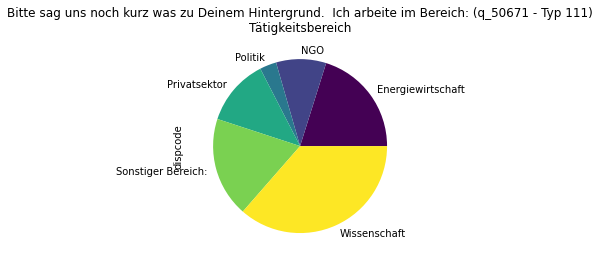

In [9]:
pie_plots(40)

In [10]:
print_data('v_306', np.mean, title='Durchschnittliche Jahre der Erfahrung')

Durchschnittliche Jahre der Erfahrung
alle: 12.875


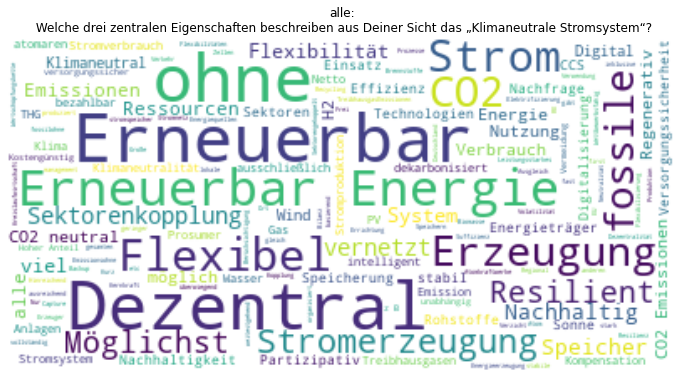

[]

In [11]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[4])

# Teil 1

Beschreibung generell

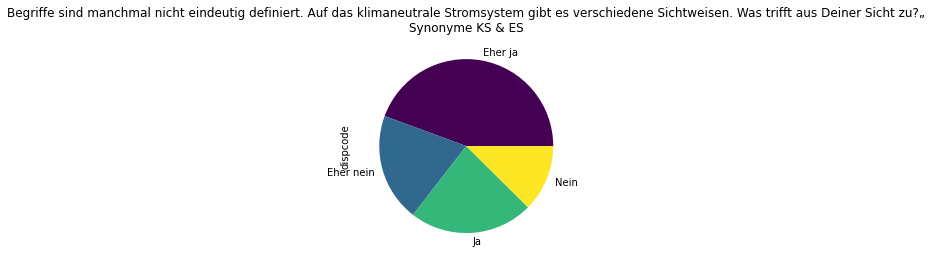

In [12]:
pie_plots(5)

<AxesSubplot:xlabel='v_137', ylabel='v_425'>

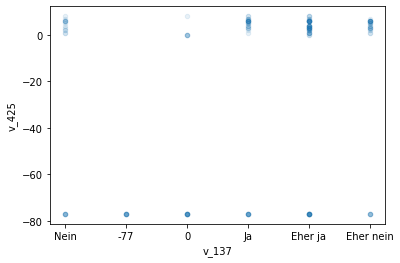

In [13]:
# Korrelation von CCS iAv Synonym-Frage
data.plot.scatter(x='v_137', y='v_425', alpha=.1)

<AxesSubplot:xlabel='v_137', ylabel='v_426'>

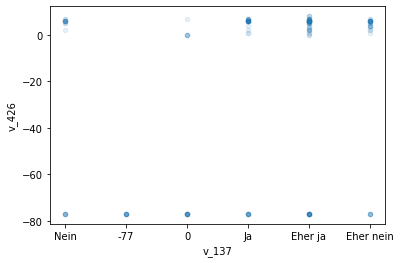

In [14]:
# Atom
data.plot.scatter(x='v_137', y='v_426', alpha=.1)

In [15]:
print_data('v_138', list, title=codebook[6]['question'], gap=True)

Was ist der Unterschied zwischen dem „Klimaneutralen Stromsystem“ und „Erneuerbaren Stromsystem“? (q_47506 - Typ 142)

alle: ['Klimaneutral geht nur global und bezieht sich ja auf THG-Konzentrationen insgesamt und den damit verbundenen zusätzlichen Strahlungsantrieb so weit zu senken, dass in einer Zeitspanne X (z.B. 2005 - 2100 zu keiner weiteren Temperaturerwärmung kommt). Erneuerbares Stromsystem bedeutet nur, dass es im besten Fall Strom aus Erneuerbaren erzeugt wird. Zur Klimaneutralität trägt das ggf. bei reicht aber bei weitem nicht aus. ', 'Klimaneutrales Stromsystem beinhaltet Atomenergie; erneuerbar nicht', 'klimaneutral kann im Zweifelsfall auch die Kompensation von Emissionen durch Ersatzmaßnahmen bedeuten', 'Stromsystem befasst sich mit der Stromerzeugung alleine, das Energiesystem betrachtet alle Energiesektoren (Gebäude, Industrie, Verkehr)', '- Zum einen ist der Begriff  Erneuerbares Stromsystem  schwierig, weil ja nicht das Stromsystem  erneuerbar  ist, sondern wenn üb

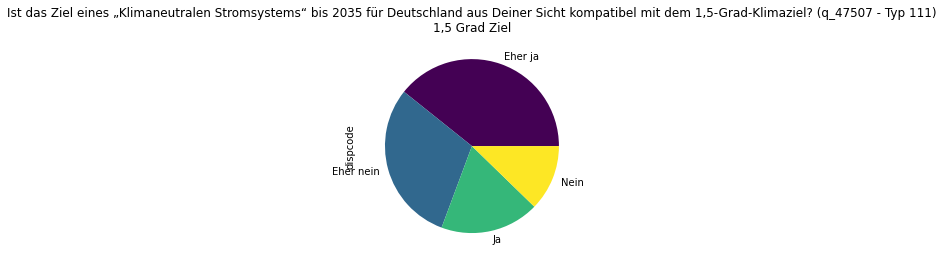

In [16]:
pie_plots(7)

<AxesSubplot:xlabel='v_137', ylabel='v_139'>

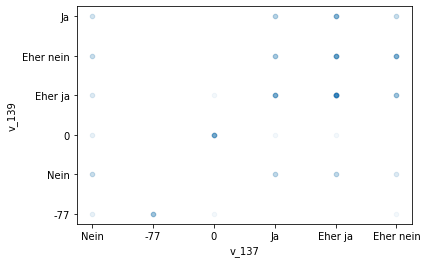

In [17]:
# Korrelation 1,5° i.A.v. Synonym
data.plot.scatter(x='v_137', y='v_139', alpha=.05)

In [18]:
print_data('v_434', list, title=codebook[8]['question'], gap=True)

Warum ist es nicht kompatibel, was fehlt Dir? (q_51785 - Typ 142)

alle: ['Was bedeutet kompatibel? 1,5 ° C sind m.E. eh durch die Verzögerung des Klimas auf die Konzentrationen eh nicht mehr zu schaffen. Trotzdem braucht es ein erneuerbares Stromsystem..', '(möglichst) kKlimaneutrale Wärme, Verkehr, Landwirtschaft', 'Die Frage wird sein, wie viel der notwendigen Elekrtrifizierung der Bereiche Industrie, Verkehr und Wärme bis dahin erreicht ist. ', 'CO2-Budgets, die bis Erreichen des 1,5 Gradzieles noch zur Verfügung stehen', 'eine ganzheitliche Betrachtung', 'Das CO2 budget deutschlands ist bis 2035 bereits mehr als aufgebraucht', 'Das 1.5° Ziel benötigt mehr als lediglich einen klimaneutralen Stromsektor. Da die nachgefragte Strommenge steigen wird, sollte der Stromsektor so schnell es geht erneuerbar werden, 2030 z.B.  ', 'Bis 2035 wird weiterhin zu viel Strom aus fossilen Kraftwerken erzeugt. Faires CO2-Budget wird gerissen', 'KN-Strom bis 2035 zu spät für 1,5 Grad, Ausbau erneuerb

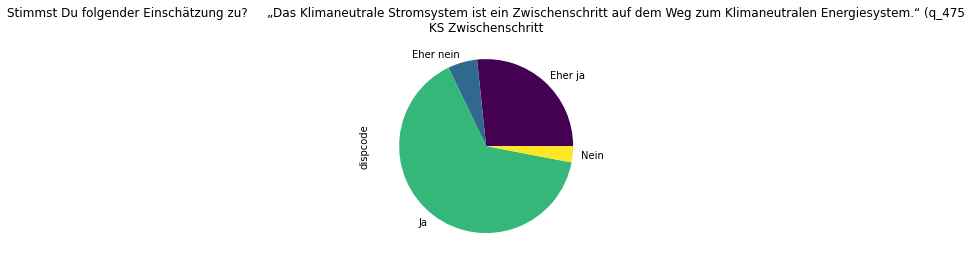

In [19]:
pie_plots(9)

In [20]:
print_data('v_171', list, title=codebook[10]['question'], gap=True)

Wie würdest Du dann das Verhältnis des Klimaneutralen Stromsystems zum Klimaneutralen Energiesystem beschreiben? (q_50620 - Typ 142)

alle: ['klimaneutrales Stromsystem ist eher Augenwischerei im Interesse der Laufzeitverlängerung der fossilen/atomaren Energieversorgung und dient der Ruhigstellung derer, die den Unterschied nicht kennen und / oder glauben, das sei das Selbe.', 'Mehr Gleichzeitigkeit erforderlich, keine Zeit für ein Nacheinander', 'Ein Klimaneutrales Energiesystem verlagert alle Energiebedarfe in das Stromsystem. Dieses muss daher in anderer Weise ausgebaut werden als bei reiner Strombetrachtung. Insbesondere ermöglicht die zunehmende Dezentralität sowohl der Stromerzeugung als auch deren Flexibilität bei der Nutzung (insb. Lastverschiebung von Wärmepumpen und E-Autoladen) neue und sehr viel effizientere (daher auch schnellere) Umsetzung dezentralerer Systemtopologien (inkl. Local Balancing zur Reduktion des Netzausbaubedarfs). Da diese jedoch auch in die gebaute Infras

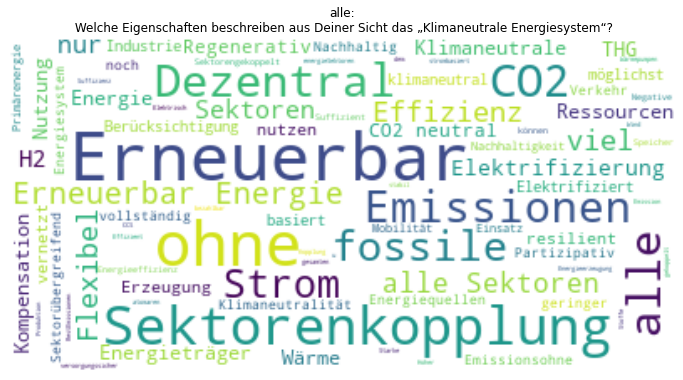

[]

In [21]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[11])

In [22]:
print_data('v_148', np.mean, codebook[12]['subquestion'][1]['question'])

Und nun denken wir an die Zielsysteme: Welchen Strombedarf wird Deutschland haben?  -  Im Klimaneutralen Stromsystem (q_47516 - Typ 911)
alle: 982.6209677419355


In [23]:
print_data('v_149', np.mean, codebook[12]['subquestion'][2]['question'])

-  Im Klimaneutralen Energiesystem (q_47517 - Typ 911)
alle: 1732.0982142857142


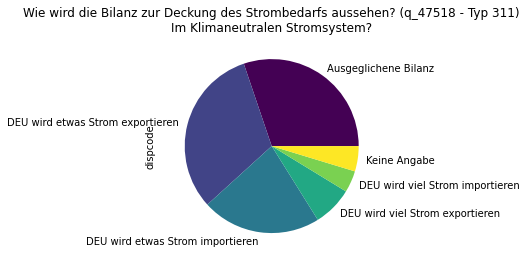

In [24]:
pie_plots(13)

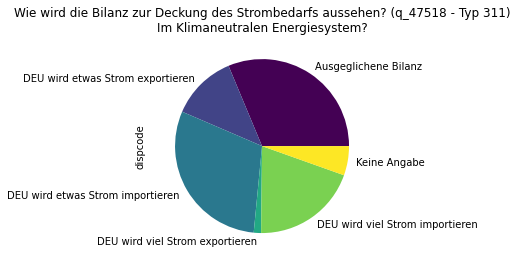

In [25]:
pie_plots(13, sub=2)

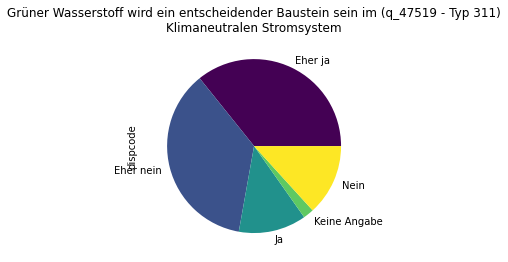

In [26]:
pie_plots(14)

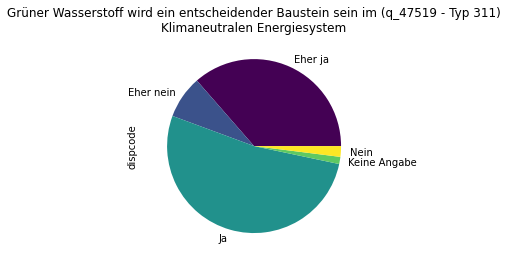

In [27]:
pie_plots(14,sub=2)

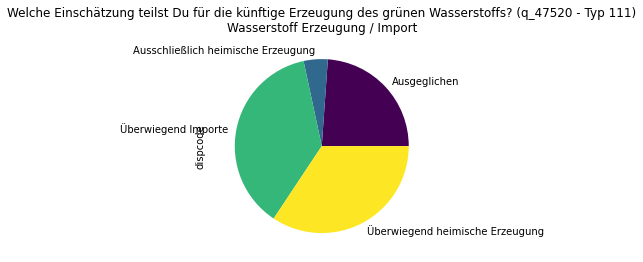

In [28]:
pie_plots(15)

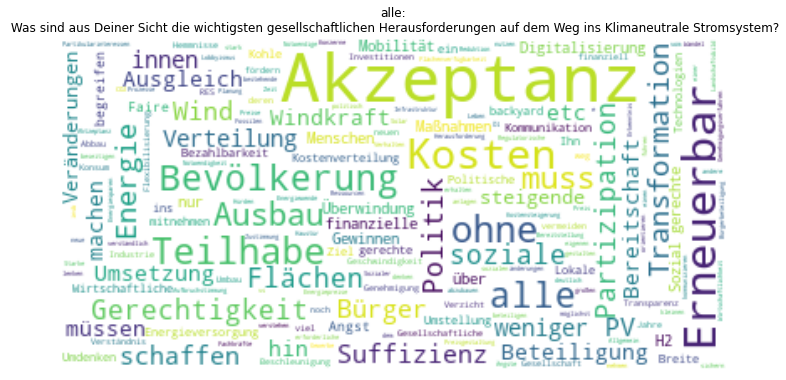

[]

In [29]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[16])

# Teil Gesellschaft

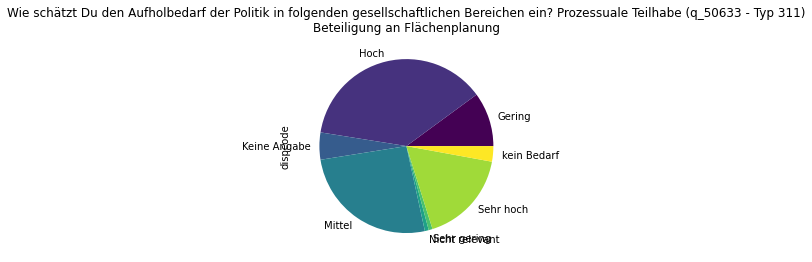

In [30]:
pie_plots(17)

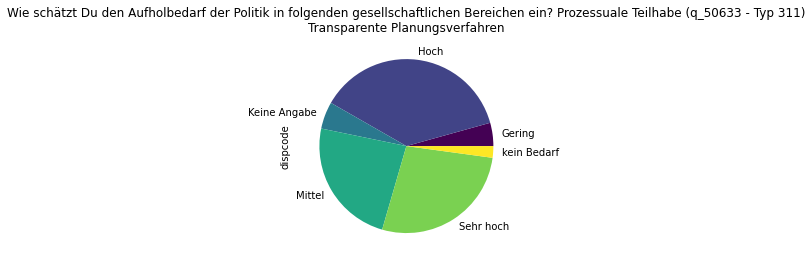

In [31]:
pie_plots(17,sub=2)

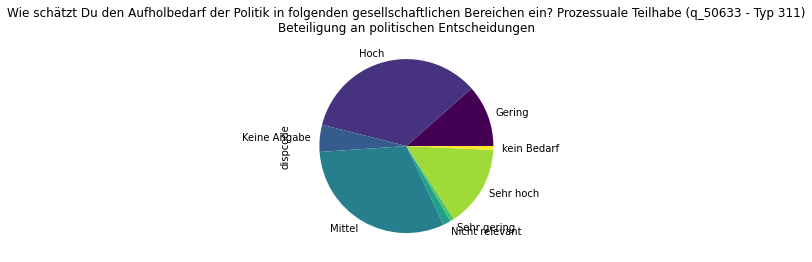

In [32]:
pie_plots(17, sub=3)

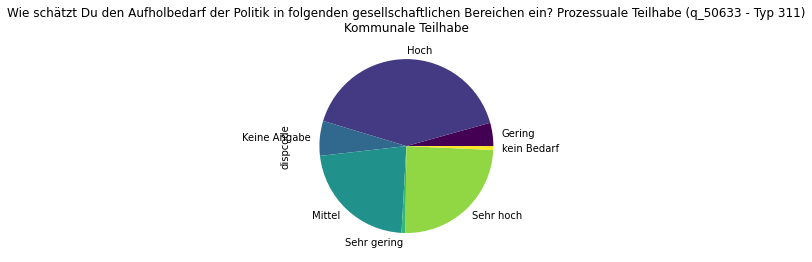

In [33]:
pie_plots(17, sub=4)

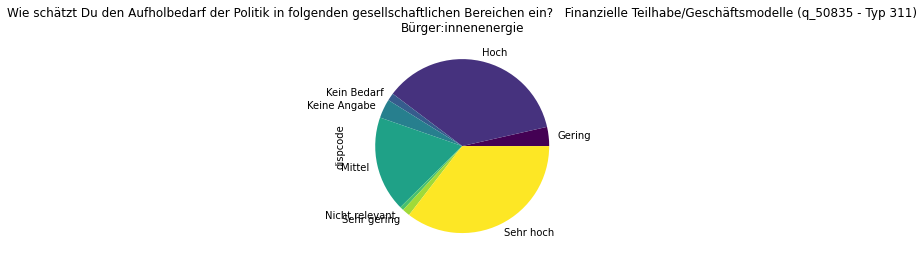

In [34]:
pie_plots(18)

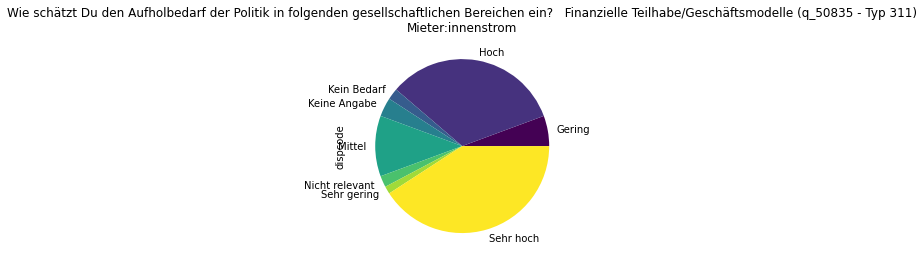

In [35]:
pie_plots(18, sub=2)

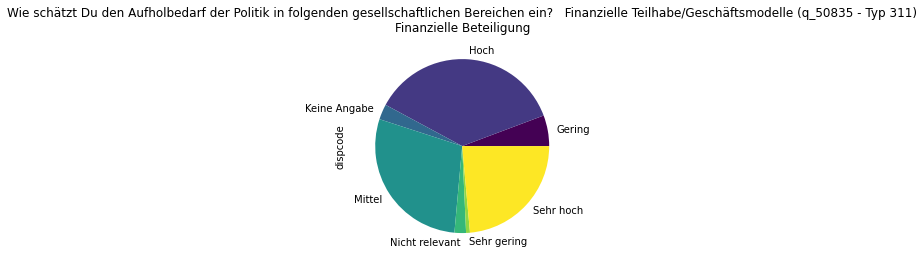

In [36]:
pie_plots(18,sub=3)

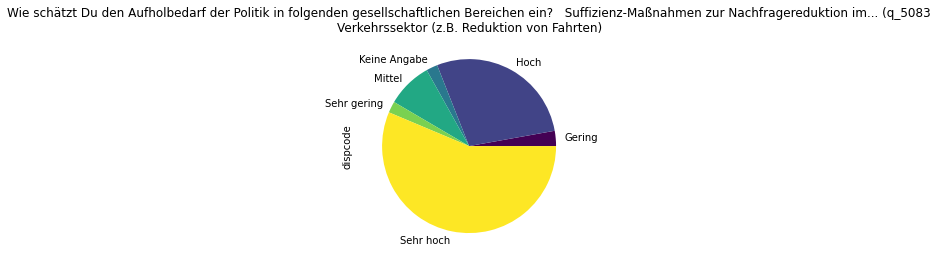

In [37]:
pie_plots(19)

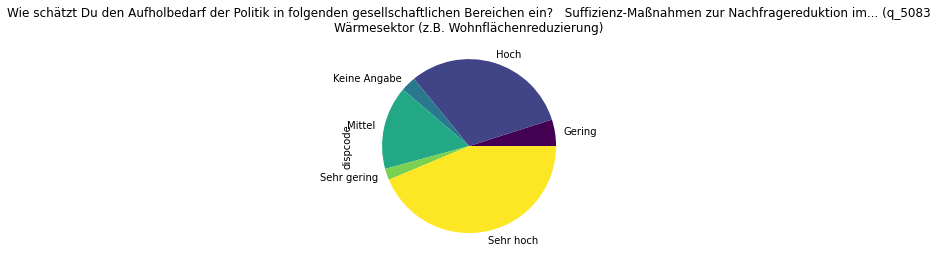

In [38]:
pie_plots(19, sub=2)

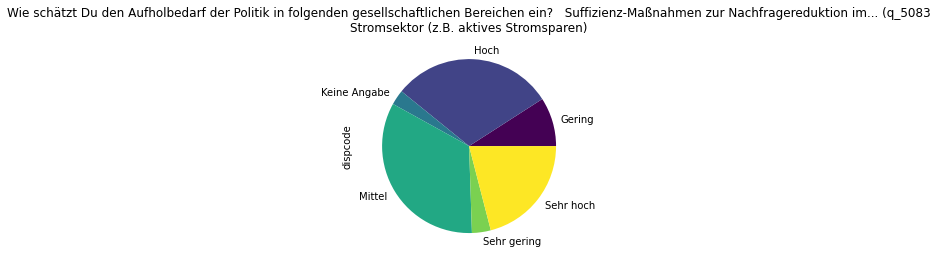

In [39]:
pie_plots(19, sub=3)

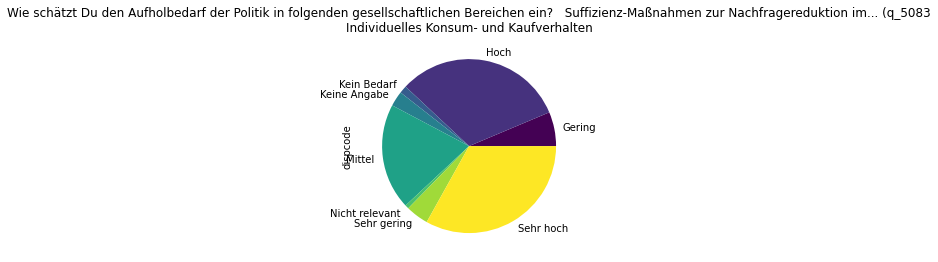

In [40]:
pie_plots(19, sub=4)

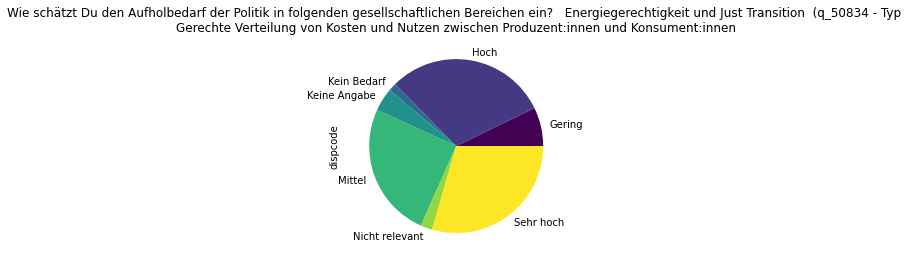

In [41]:
pie_plots(20, sub=1)

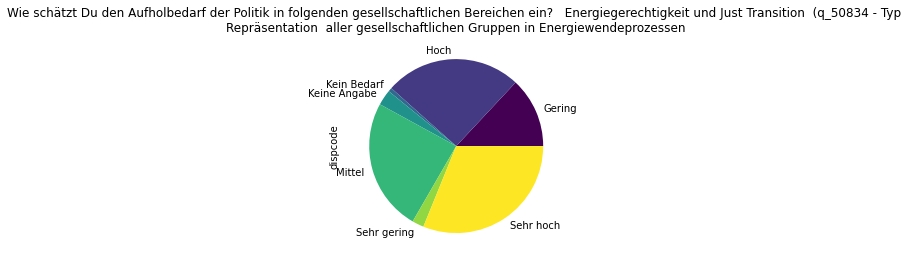

In [42]:
pie_plots(20, sub=2)

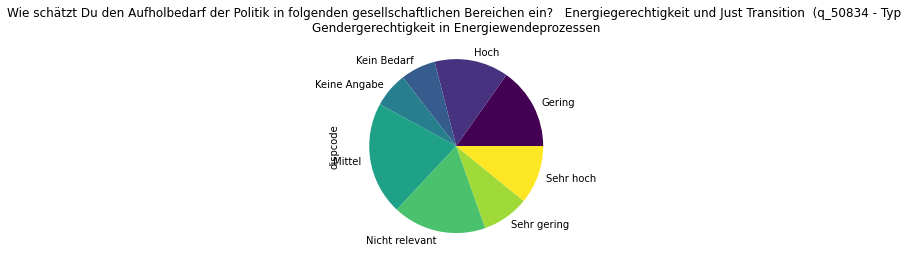

In [43]:
pie_plots(20, sub=3)

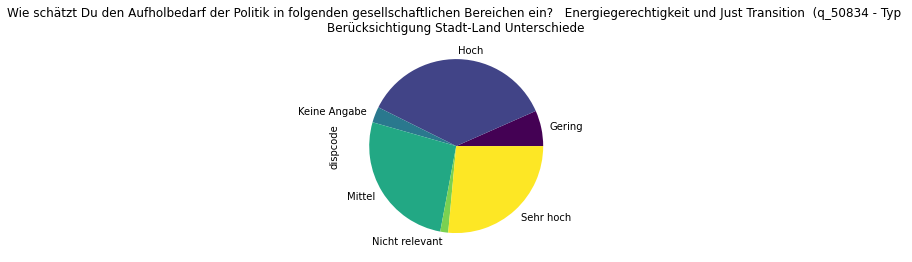

In [44]:
pie_plots(20, sub=4)

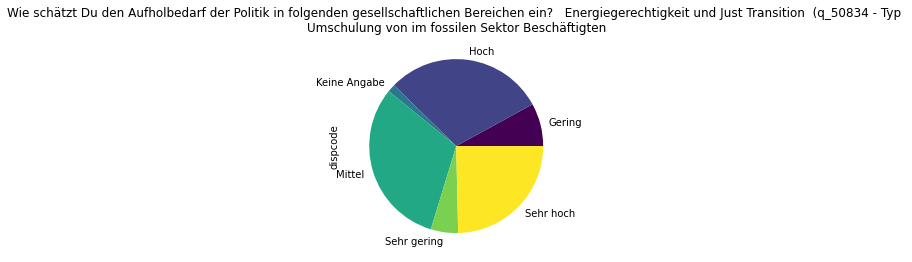

In [45]:
pie_plots(20, sub=5)

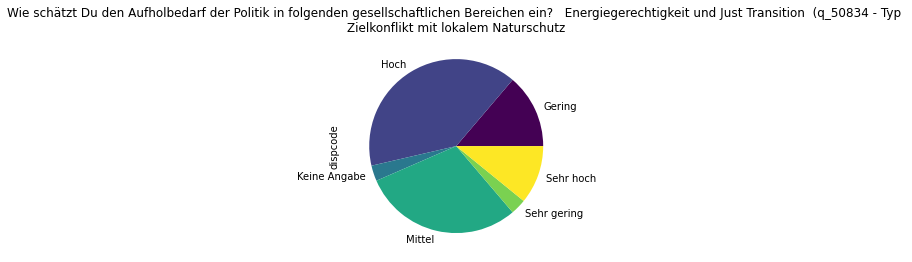

In [46]:
pie_plots(20, sub=6)

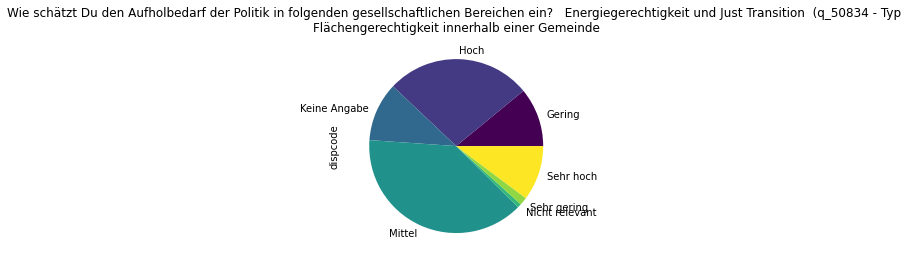

In [47]:
pie_plots(20, sub=7)

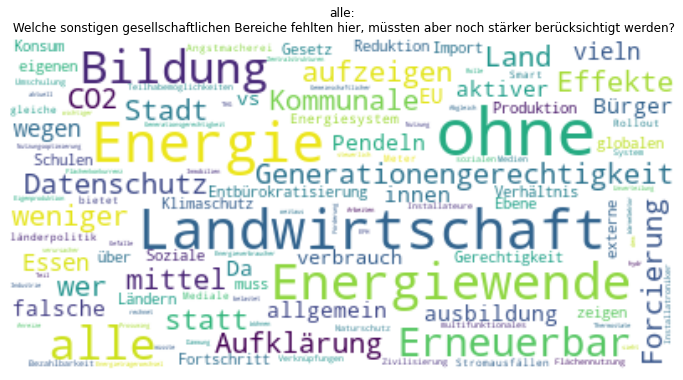

[]

In [48]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[21])

# Teil Wirtschaft

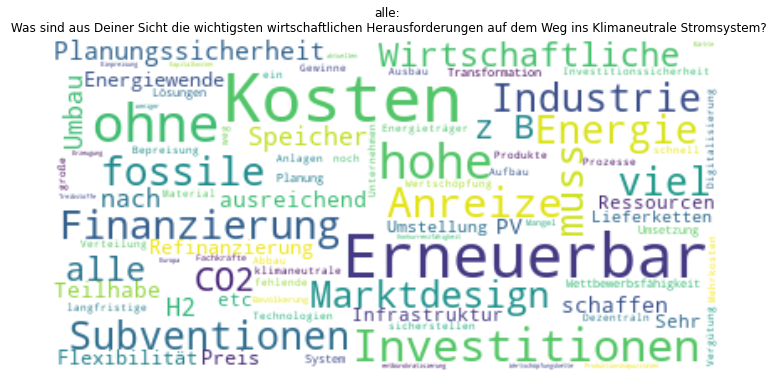

[]

In [49]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[22])

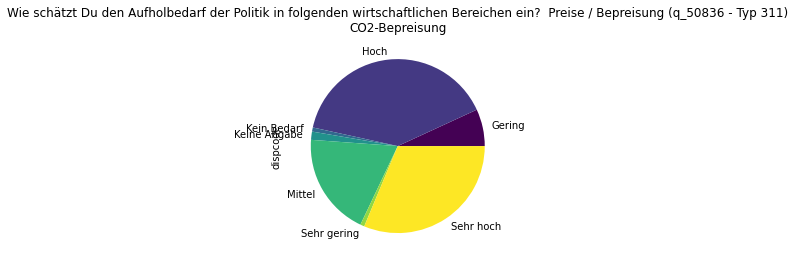

In [50]:
pie_plots(23, sub=1)

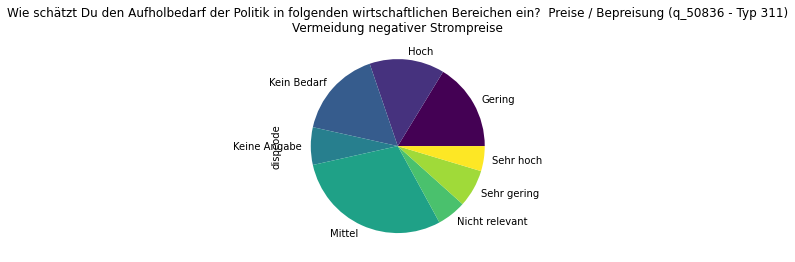

In [51]:
pie_plots(23, sub=2)

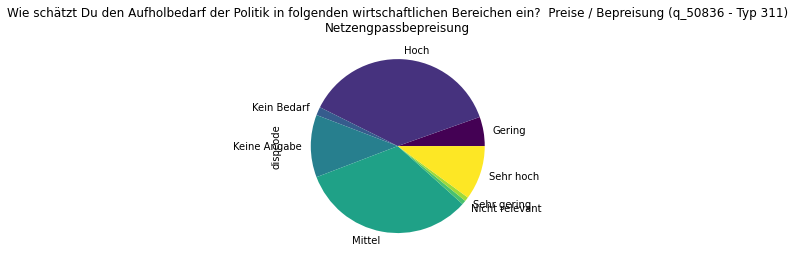

In [52]:
pie_plots(23, sub=3)

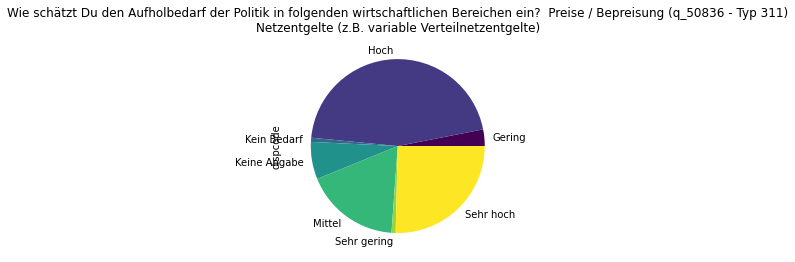

In [53]:
pie_plots(23, sub=4)

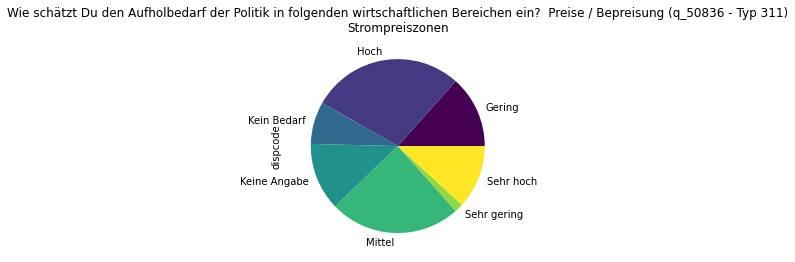

In [54]:
pie_plots(23, sub=5)

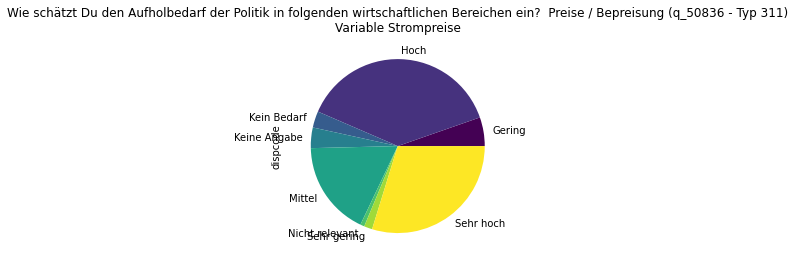

In [55]:
pie_plots(23, sub=6)

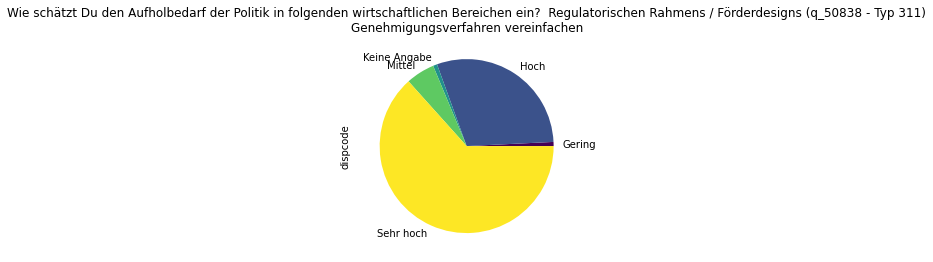

In [56]:
pie_plots(24, sub=1)

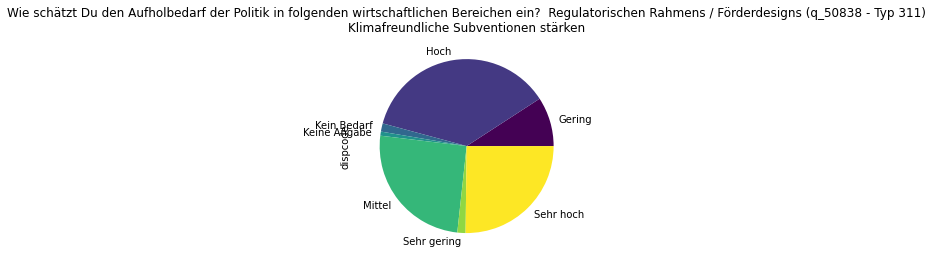

In [57]:
pie_plots(24, sub=2)

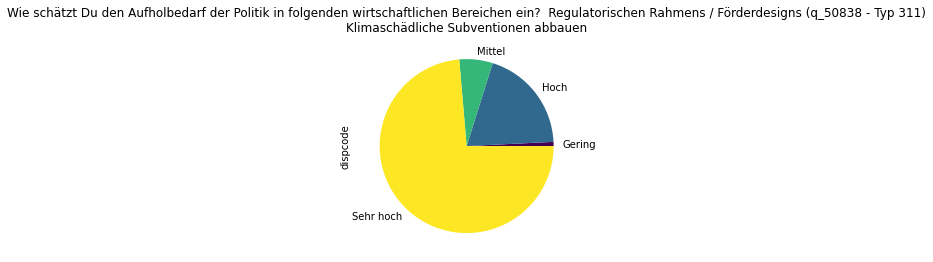

In [58]:
pie_plots(24, sub=3)

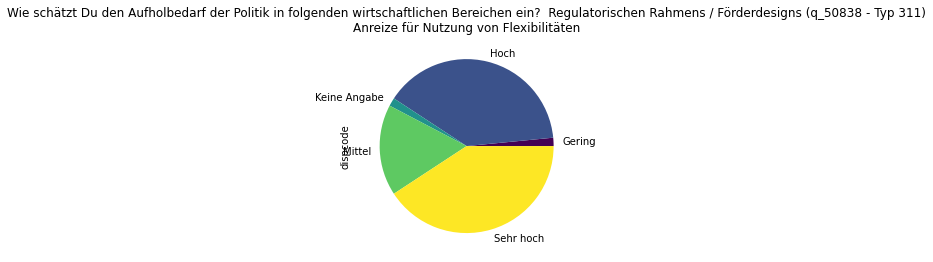

In [59]:
pie_plots(24, sub=4)

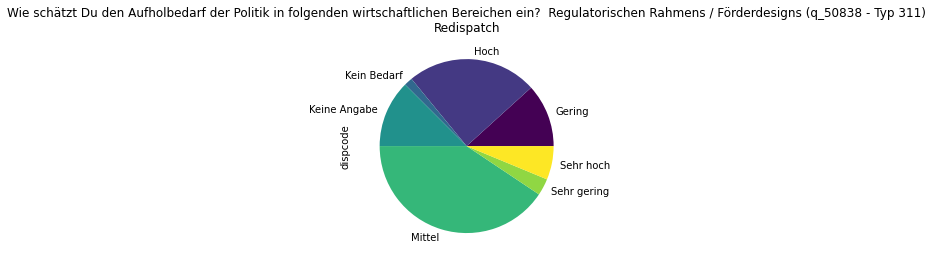

In [60]:
pie_plots(24, sub=5)

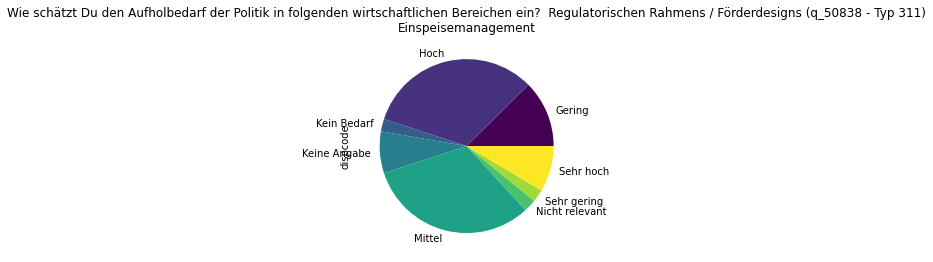

In [61]:
pie_plots(24, sub=6)

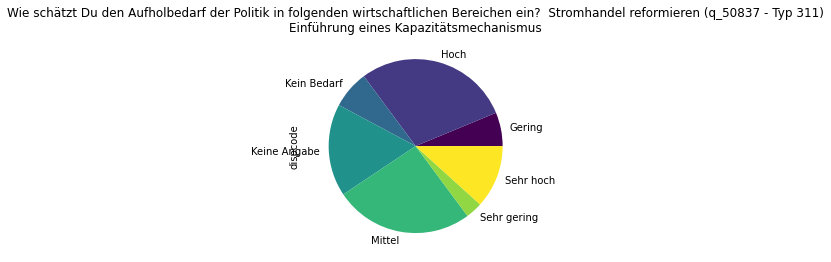

In [62]:
pie_plots(25, sub=1)

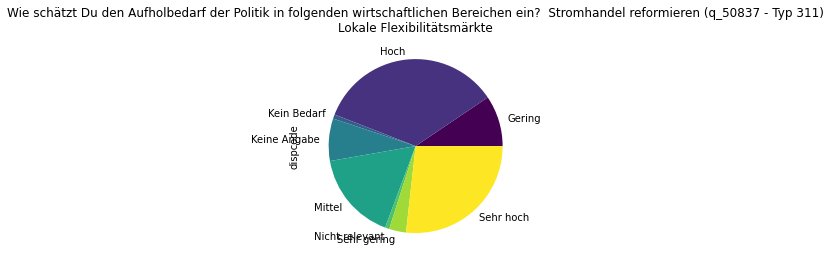

In [63]:
pie_plots(25, sub=2)

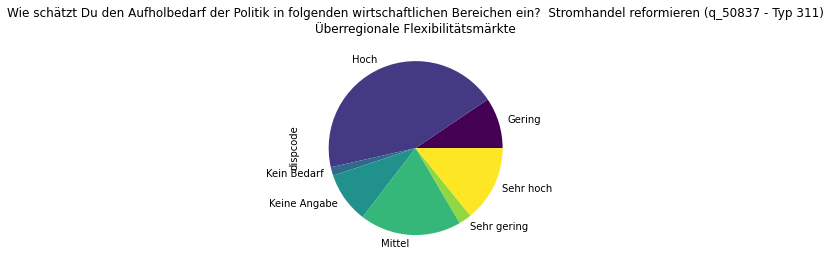

In [64]:
pie_plots(25, sub=3)

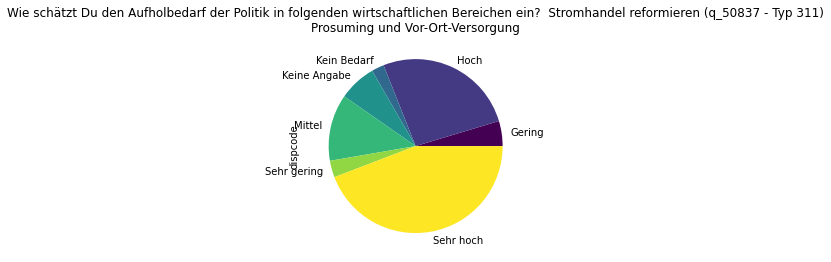

In [65]:
pie_plots(25, sub=4)

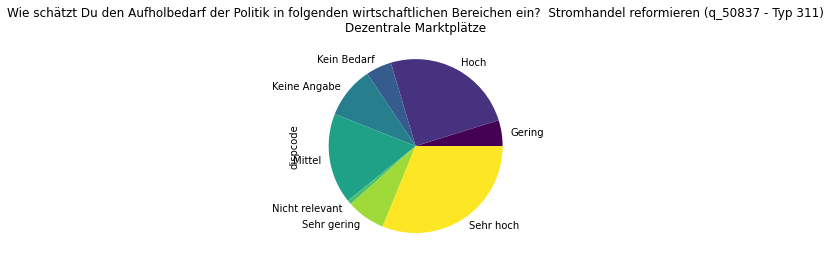

In [66]:
pie_plots(25, sub=5)

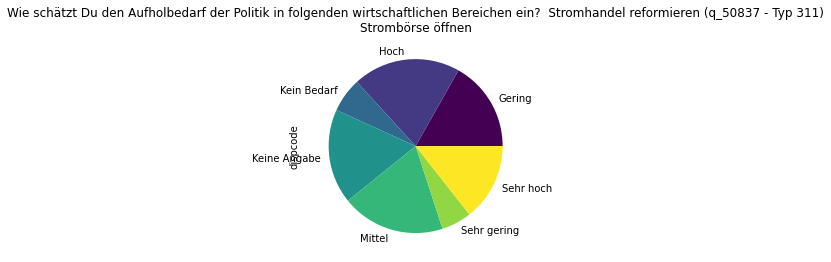

In [67]:
pie_plots(25, sub=6)

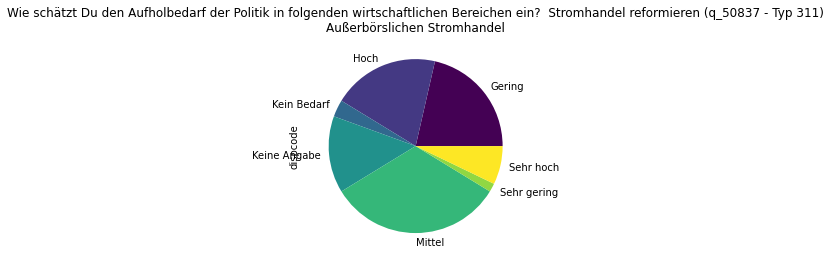

In [68]:
pie_plots(25, sub=7)

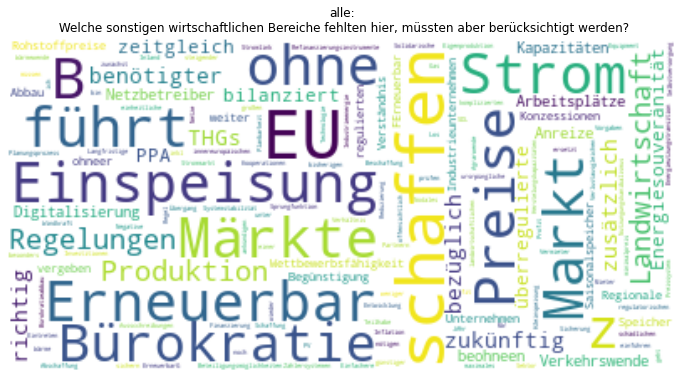

[]

In [69]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[26])

# Teil Technik

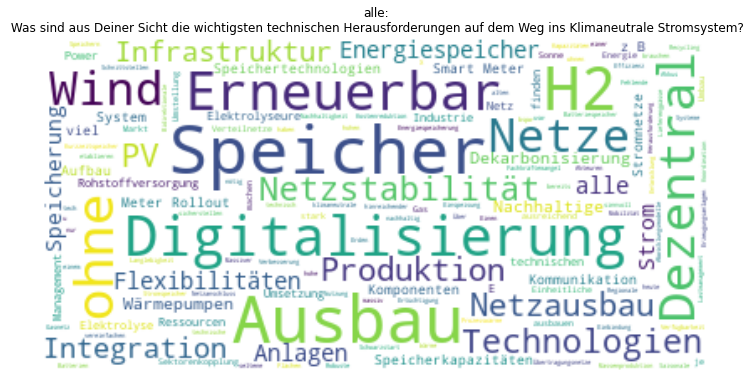

[]

In [70]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[27])

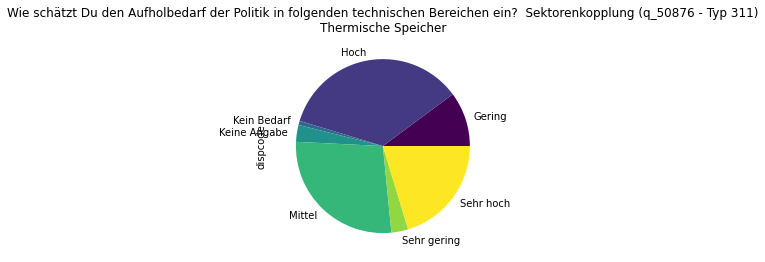

In [71]:
pie_plots(28, sub=1)

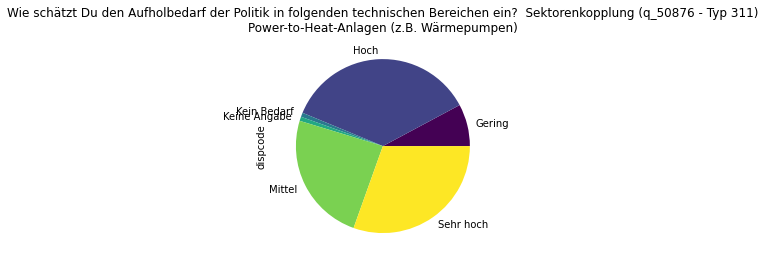

In [72]:
pie_plots(28, sub=2)

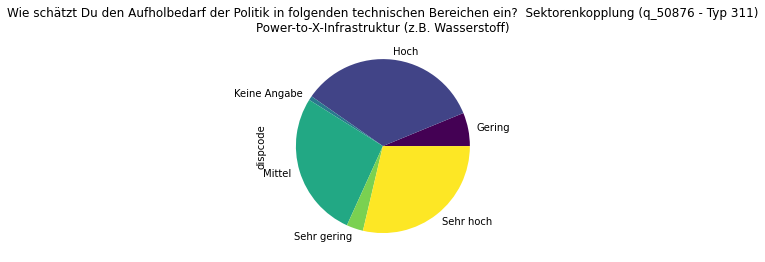

In [73]:
pie_plots(28, sub=3)

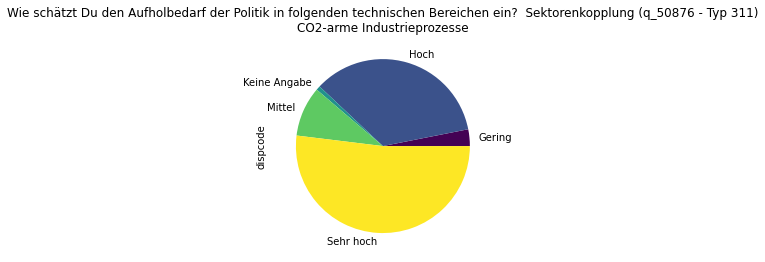

In [74]:
pie_plots(28, sub=4)

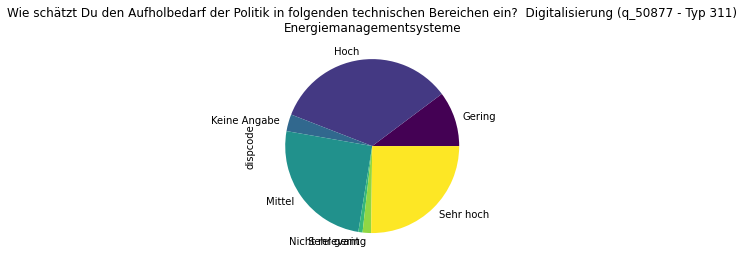

In [75]:
pie_plots(29, sub=1)

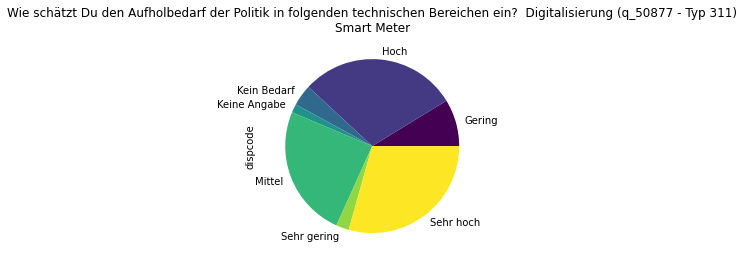

In [76]:
pie_plots(29, sub=2)

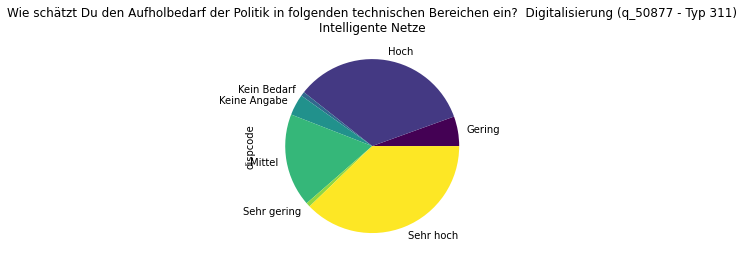

In [77]:
pie_plots(29, sub=3)

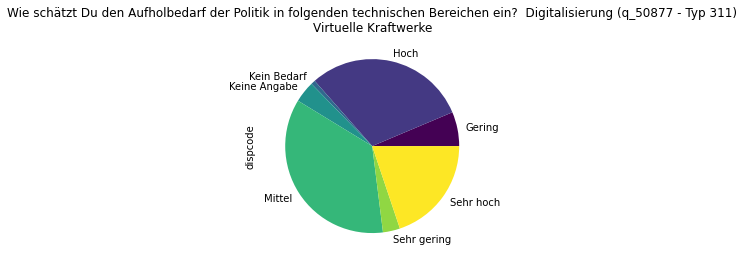

In [78]:
pie_plots(29, sub=4)

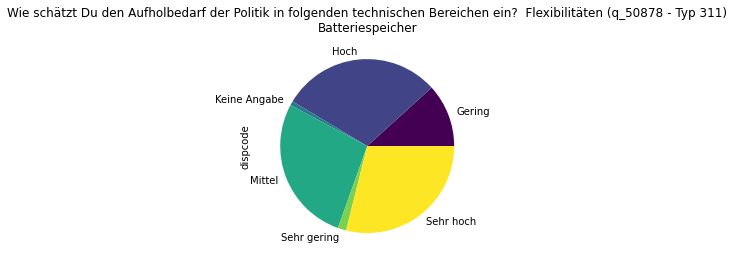

In [79]:
pie_plots(30, sub=1)

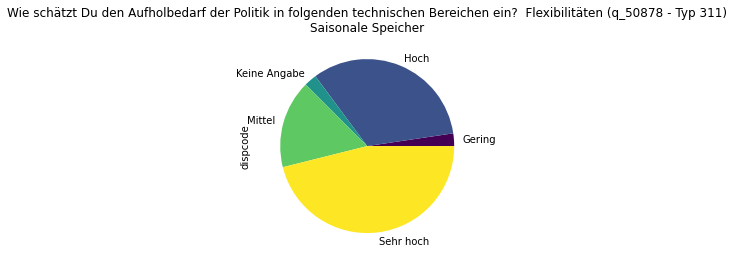

In [80]:
pie_plots(30, sub=2)

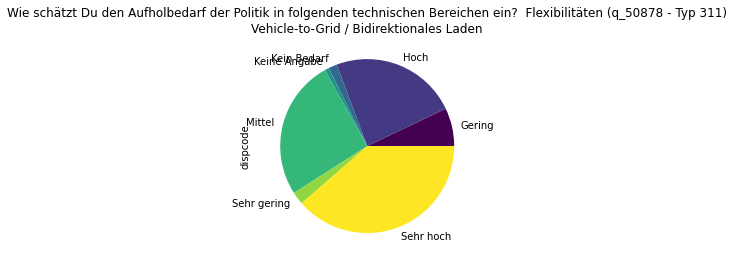

In [81]:
pie_plots(30, sub=3)

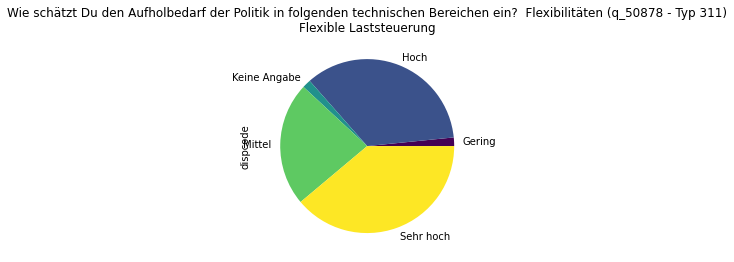

In [82]:
pie_plots(30, sub=4)

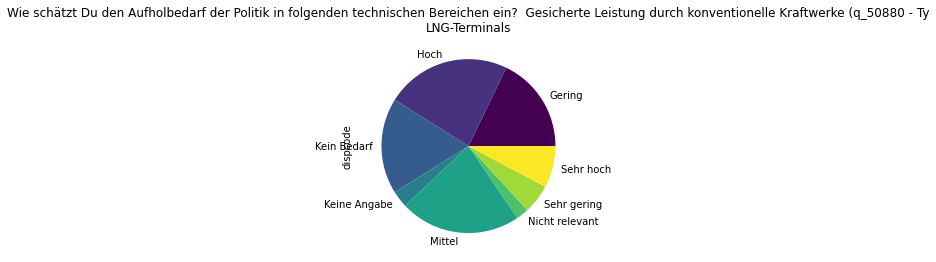

In [83]:
pie_plots(31, sub=1)

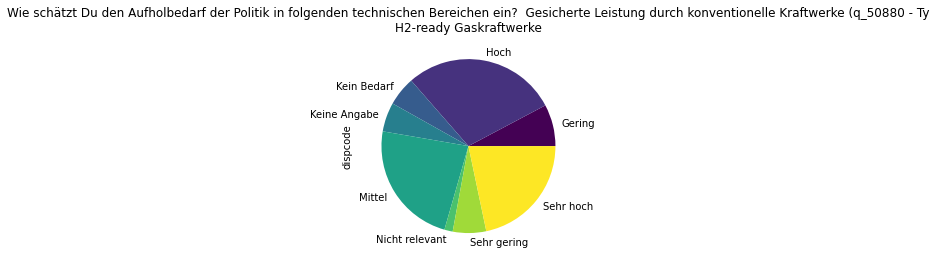

In [84]:
pie_plots(31, sub=2)

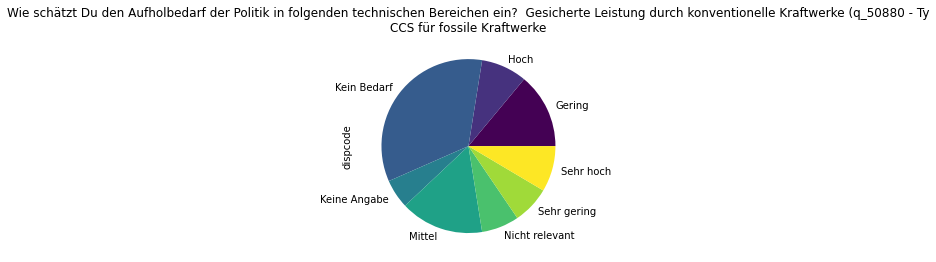

In [85]:
pie_plots(31, sub=3)

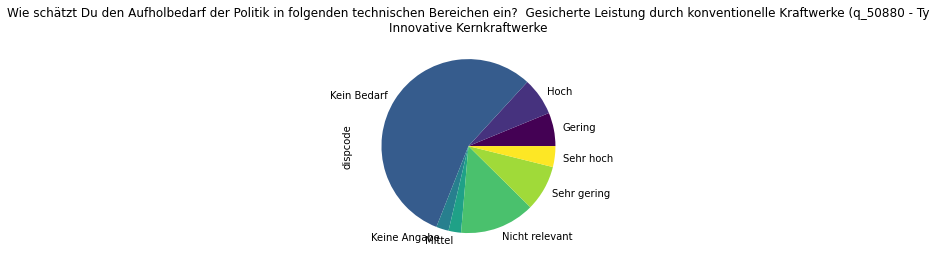

In [86]:
pie_plots(31, sub=4)

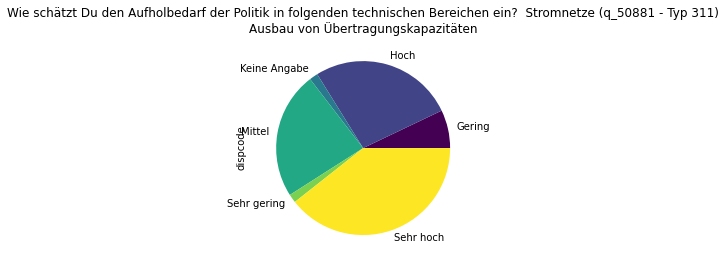

In [87]:
pie_plots(32, sub=1)

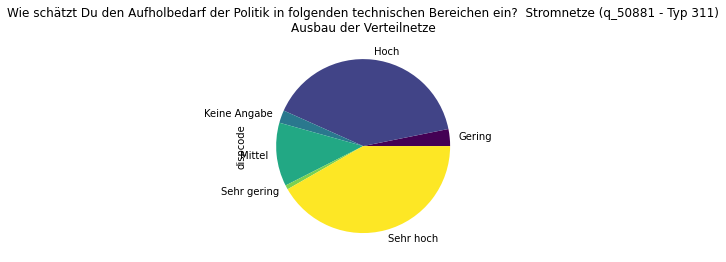

In [88]:
pie_plots(32, sub=2)

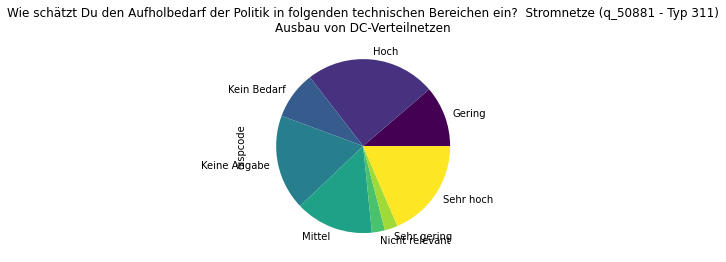

In [89]:
pie_plots(32, sub=3)

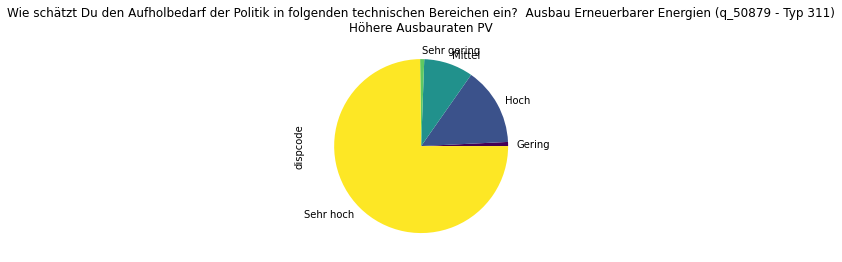

In [90]:
pie_plots(33, sub=1)

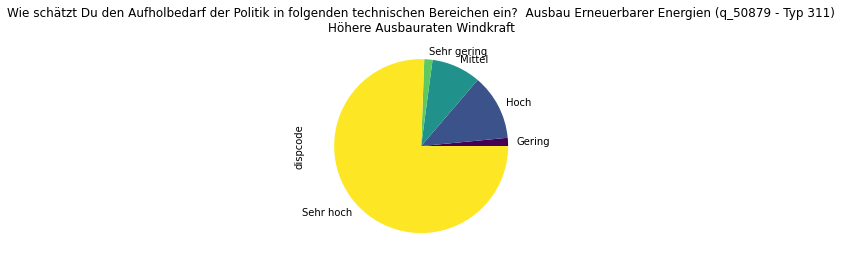

In [91]:
pie_plots(33, sub=2)

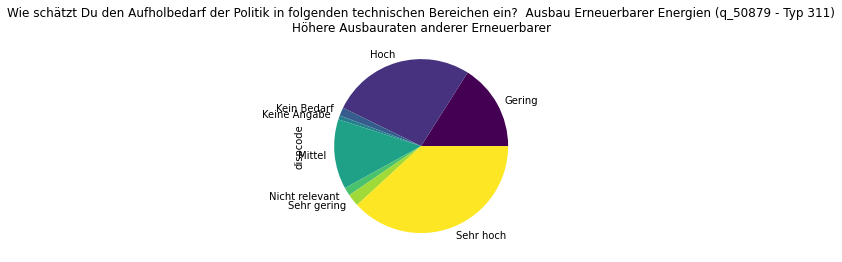

In [92]:
pie_plots(33, sub=3)

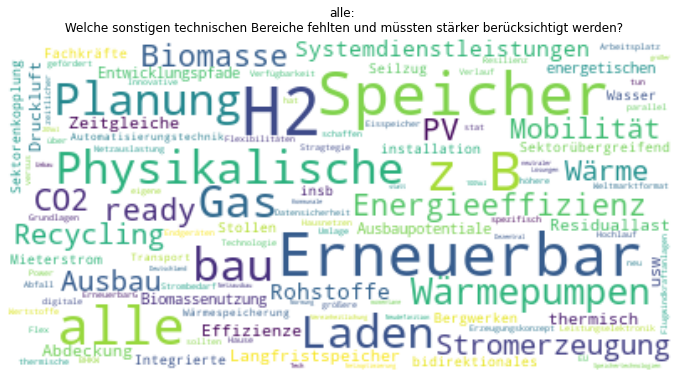

[]

In [93]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[34])

# Teil Strommarktdesign

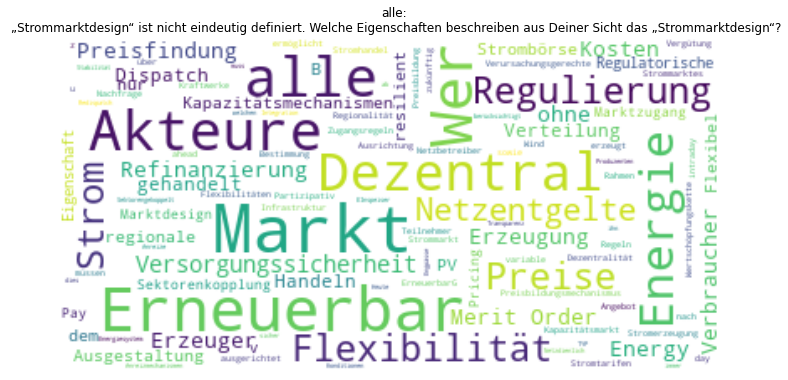

[]

In [94]:
# Keine Priorisierung der Felder (1., 2., 3.)
rls_umfrage_auswertung.create_wordclouds(codebook, survey_data=data, survey_group='alle', question_number_list=[35])

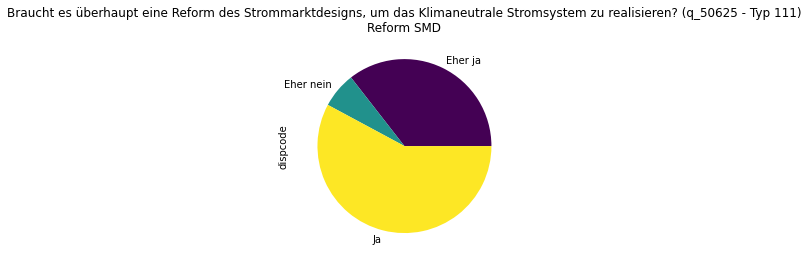

In [95]:
pie_plots(36)

In [96]:
print_data('v_205', list, title=codebook[37]['question'], gap=True)

Welche konkreten Wünsche und Erwartungen hast Du an eine Reform des Strommarktdesigns? (q_50630 - Typ 143)

alle: ['Teilhabe neuer Stakeholder, kleinteiliger Anlagen', 'Die geringen EE-Grenzkosten erfordern einen Leistungspreis (=>Kapazitätsmarkt)', 'Eine Betrachtung, was in integrierten Strukturen günstiger wäre als durch div. Schnittstellen, Fehlerquellen und Ineffizienzen durch die Liberalisierung', 'partizipativ', 'Abkehr von Grenzkosten', 'Anpassungen des aktuellen Ausschreibungsdesigns im EEG', 'grenzkosten null EE tauglich', 'Faire Verteilung der kosten auf Nutzer ', 'größtmögliche Beschleunigung der Energiewende', 'Fokus auf EE und nicht mehr Gas', 'Kurzfristige Engpasssignale (Regionale Flexibilitätsmärkte)', 'Ist Energie Only langfristig Zielführend, wenn die var. Erzeugungskosten längerfristig verschwinden?', 'Übertragungskapazitäten sind im Marktdesign verankert', 'Verknüpfung von technischer Seite (Netze) mit der ökonomischen (Märkte)', 'Flexibilitäten (als Konzession regi

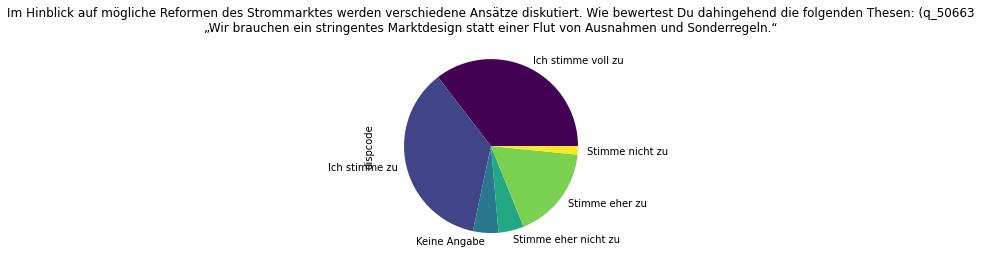

In [97]:
pie_plots(38, sub=1)

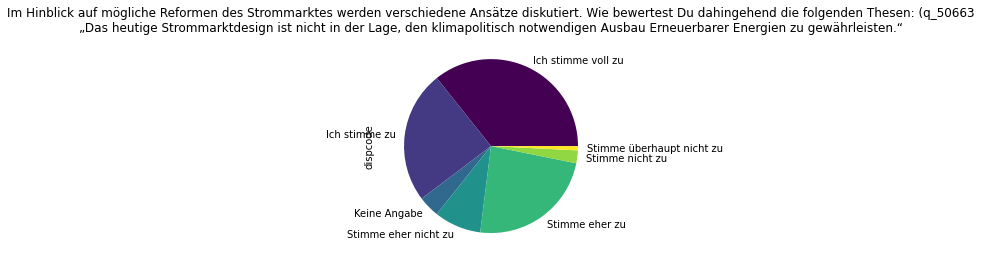

In [98]:
pie_plots(38, sub=2)

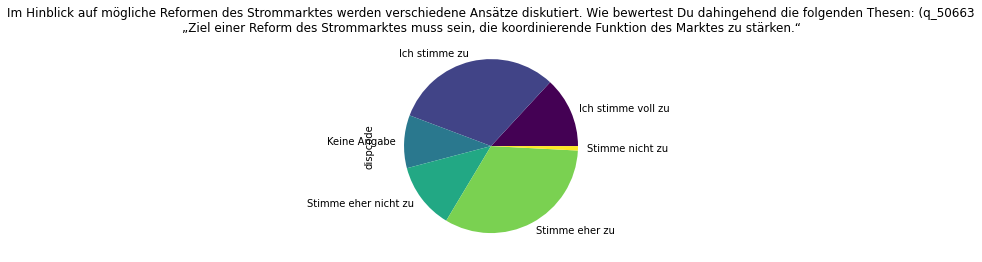

In [99]:
pie_plots(38, sub=3)

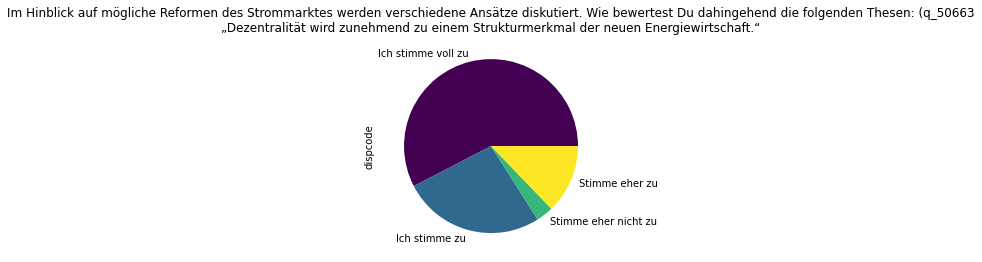

In [100]:
pie_plots(38, sub=4)

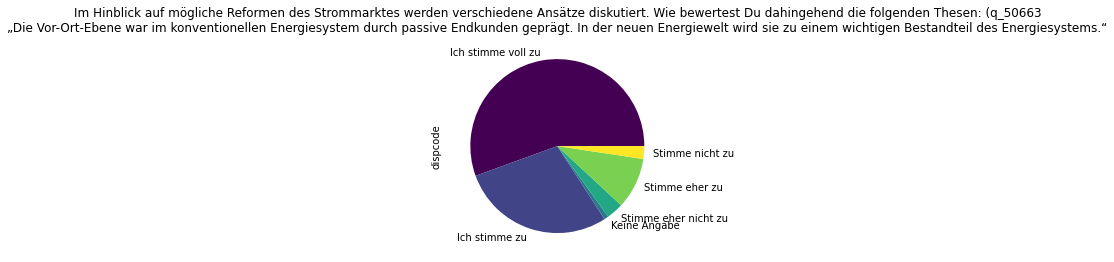

In [101]:
pie_plots(38, sub=5)

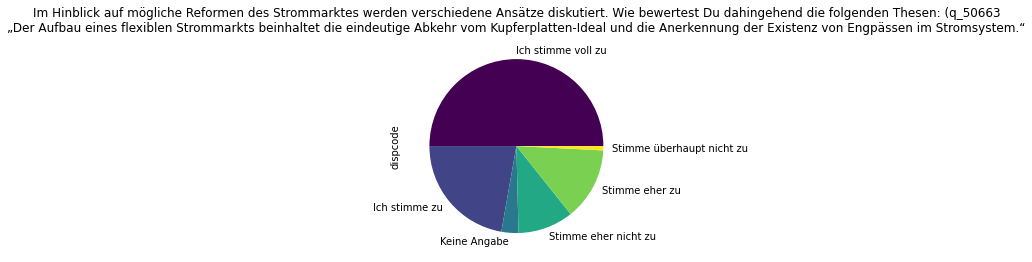

In [102]:
pie_plots(38, sub=6)

In [103]:
print_data('v_273', list, title=codebook[39]['question'], gap=True)

Welche These fehlt Dir, die Du zur Beschreibung der Herausforderung wichtig findest? (q_50665 - Typ 142)

alle: ['Die Illusion der Prosumer wird aufrechtgehalten für und durch eine kleine Gruppe von aktiven, interessierten Kunden - das zukünftige Marktdesign muss sich an den mehr als 90% der Kunden orientieren, denen die Energieversorgung völlig egal ist, solange Kühlschrank, Fernseher und Heizung laufen.  Selbst im gewerblichen Bereich sind die grösste ZAHL der Kunden desinteressiert. Nur energieintensive Betriebe sind aktiv in Flexibilität und KOstensenkungspotentialen.', 'Die Grenzkosten basierte Preisfindung ist einem EE geprägten System keine geeignete Größe zur Preisfindung', 'Das Strommarktdesign wurde bislang oft vom Status Quo schrittweise angepasst und ist aber im Kern nach wie vor auf die Verhältnisse von vor 20 Jahren zu geschnitten. Das neue Strommarktdesign sollte vom Ziel her konzipiert sein und für die Stromversorgung in 20 Jahren die Richtigen Bedingungen schaffen.', '